### Import libraries

In [1]:
#import required libraries
import numpy as np
import pandas as pd
from PIL import Image,ImageOps
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from tensorflow.keras.applications.mobilenet import MobileNet,preprocess_input
from tensorflow.keras.layers import Dense, UpSampling2D, BatchNormalization, Input,Dropout,Conv2DTranspose,Conv2D,Concatenate,Reshape,Activation,MaxPooling2D
from tensorflow.keras import Model,Sequential
import tensorflow as tf
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.applications import mobilenet,mobilenet_v2,VGG16
from tensorflow.keras.backend import log, epsilon
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.preprocessing.image import  ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K

In [2]:
import random
random.seed(0)

import warnings
warnings.filterwarnings("ignore")

## Import the dataset.

In [5]:
movieData=np.load('Train_images.npy',allow_pickle=True)

In [6]:
movieData.shape

(409, 2)

In [8]:
length= len(movieData)
labels= []
images=[]
for mov in range(length):
    labels.append(movieData[mov][1])
    images.append(movieData[mov][0])

### Display images

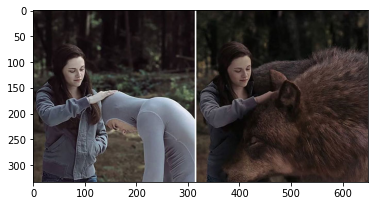

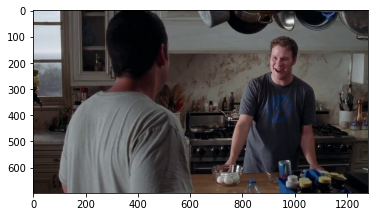

In [48]:
for i in range(0,2):
    plt.imshow(images[i])
    plt.show()

### Create masks

In [60]:
def createImagesMasksSet():
    MaskedImages_label=[]
    for i in range(len(labels)):
        img=Image.fromarray(images[i])
        img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR) 
        mask = np.zeros(img.shape[:2], dtype="uint8")
        for j, lab in enumerate(labels[i]):
            imageWidth = lab['imageWidth']
            imageHeight=lab['imageHeight']
            x1 = round(imageWidth*lab['points'][0]['x'])
            y1 = round(imageHeight*lab['points'][0]['y'])
            x2 = round(imageWidth*lab['points'][1]['x'])
            y2 = round(imageHeight*lab['points'][1]['y'])
            cv2.rectangle(mask,(x1,y1),(x2,y2),255,-1)
            img2= cv2.bitwise_and(img, img, mask=mask)
        MaskedImages_label.append(img2)

    return MaskedImages_label

In [61]:
MaskedImages_label= createImagesMasksSet()

In [62]:
IMAGE_HEIGHT=224
IMAGE_WIDTH=224

In [63]:
train_set_images,test_set_images,train_set_masks,test_set_masks = train_test_split(images,MaskedImages_label,test_size=0.20)

In [64]:
len(train_set_images), len(train_set_masks)

(327, 327)

In [65]:
len(test_set_images), len(test_set_masks)

(82, 82)

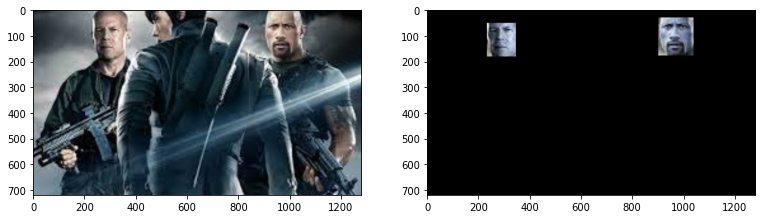

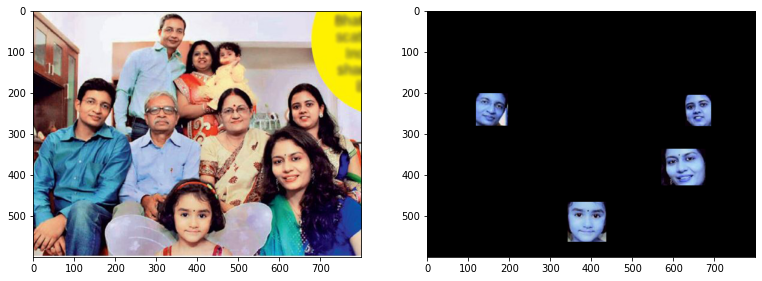

In [66]:
#Images and its mask
for y in range(0,2):
    plt.figure(figsize=(20,20))
    x=random.choice(range(len(train_set_images)))
    plt.subplot(1, 3, 1)
    plt.imshow(train_set_images[x])
    plt.subplot(1, 3, 2)
    plt.imshow(train_set_masks[x])

In [67]:
def normaliseImageMask(train_set_images,train_set_masks):
    X_train=[]
    Y_train=[]
    for i in range(len(train_set_images)):
        img = Image.fromarray(train_set_images[i])
        img =cv2.cvtColor(np.array(img),cv2.COLOR_RGB2BGR)
        img = cv2.resize(img, (IMAGE_HEIGHT, IMAGE_WIDTH))
        X_train.append(img)
    for i in range(len(train_set_masks)):
        img = train_set_masks[i]
        img =cv2.cvtColor(np.array(img),cv2.COLOR_BGR2GRAY)
        (thresh, im_bw) = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
        img = cv2.resize(np.array(im_bw), (IMAGE_HEIGHT, IMAGE_WIDTH))
        img=img.reshape(IMAGE_HEIGHT,IMAGE_WIDTH,1)
        Y_train.append(img/255)
    return np.array(X_train),np.array(Y_train)

In [68]:
X_train,Y_train= normaliseImageMask(train_set_images,train_set_masks)
X_test,Y_test= normaliseImageMask(test_set_images,test_set_masks)

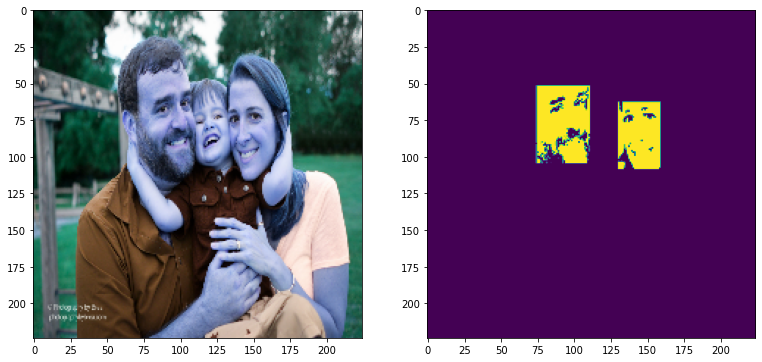

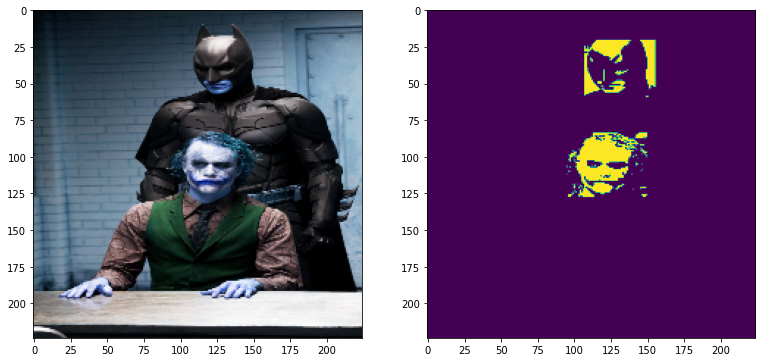

In [69]:
for y in range(0,2):
    plt.figure(figsize=(20,20))
    x=random.choice(range(len(X_train)))
    plt.subplot(1, 3, 1)
    plt.imshow(X_train[x])
    plt.subplot(1, 3, 2)
    plt.imshow(Y_train[x].reshape(224,224))
  

In [72]:
print("Dimensions of test and train set after pre-processing: \n")
print("Training:", X_train.shape )
print("Training:",  Y_train.shape)
print("Testing:", X_test.shape)
print("Testing:",Y_test.shape)
# print("Testing set  images' shape :", X_valid.shape)
# print("Testing set  masks'  shape :",Y_valid.shape)

Dimensions of test and train set after pre-processing: 

Training: (327, 224, 224, 3)
Training: (327, 224, 224, 1)
Testing: (82, 224, 224, 3)
Testing: (82, 224, 224, 1)


In [73]:
X_train_mobileNet_process = preprocess_input(X_train)
X_test_mobileNet_proces=preprocess_input(X_test)
X_valid_mobileNet_process =preprocess_input(X_valid)

## Mask detection model

In [97]:
def faceDetection_model(): 
    CVModel= MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=0.5, weights="imagenet")
    for layer in CVModel.layers:
        layer.trainable=False
    inputs = Input(IMAGE_HEIGHT,IMAGE_WIDTH,3)
    conv_layer1=CVModel.get_layer('conv_pw_1').output   #(None, 112, 112, 64)
    conv_layer2=CVModel.get_layer('conv_pw_3').output    # (None, 56, 56, 128)
    conv_layer3=CVModel.get_layer('conv_pw_5').output   #(None, 28, 28, 256)
    conv_layer4=CVModel.get_layer('conv_pw_7').output   #(None, 14, 14, 512)
    conv_layer5=CVModel.get_layer('conv_pw_12').output    # (None, 7, 7, 512)

    x = UpSampling2D(size=(2,2))(conv_layer5)
    x = Activation('relu')(x)
    x= BatchNormalization()(x)
    concat_1 = Concatenate()([x, conv_layer4])
    x = Conv2D(512, (3,3),activation='relu', padding='same', kernel_initializer='he_normal') (concat_1)

    x= UpSampling2D(size=(2,2))(x)
    x = Activation('relu')(x)
    x= BatchNormalization()(x)
    concat_2= Concatenate()([x, conv_layer3])
    x = Conv2D(256, (3,3),activation='relu', padding='same', kernel_initializer='he_normal') (concat_2)

    x= UpSampling2D(size=(2,2))(x)
    x = Activation('relu')(x)
    x= BatchNormalization()(x)
    concat_3= Concatenate()([x, conv_layer2])
    x = Conv2D(128, (3,3),activation='relu', padding='same', kernel_initializer='he_normal') (concat_3)
    x = Conv2D(128, (3,3),activation='relu', padding='same', kernel_initializer='he_normal') (x)

    x= UpSampling2D(size=(2,2))(x)
    x = Activation('relu')(x)
    x= BatchNormalization()(x)
    concat_4= Concatenate()([x, conv_layer1])
    x = Conv2D(64, (3,3),activation='relu', padding='same', kernel_initializer='he_normal') (concat_4)
    x = Conv2D(64, (3,3),activation='relu', padding='same', kernel_initializer='he_normal') (x)
    x= UpSampling2D(size=(2,2))(x)
    x= Conv2D(1, (1, 1), activation='sigmoid') (x)

    model = Model(CVModel.inputs, x)

    return model

### own Dice Coefficient and Loss function

In [99]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return numerator / (denominator + epsilon())

In [100]:
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + epsilon()

### Train the model

In [101]:
modelUnet = faceDetection_model()
modelUnet.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 16) 432         input_9[0][0]                    
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 16) 64          conv1[0][0]                      
__________________________________________________________________________________________________
conv1_relu (ReLU)               (None, 112, 112, 16) 0           conv1_bn[0][0]                   
____________________________________________________________________________________________

In [104]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('MovieFaceDetection.h5',
                                                    save_best_only=False, 
                                                    monitor=[dice_coefficient], 
                                                    mode='max', 
                                                    verbose = 1)

In [105]:
optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
modelUnet.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient])


In [106]:
history = modelUnet.fit(X_train_mobileNet_process,Y_train,
                      steps_per_epoch=X_train_mobileNet_process.shape[0]//32,
                       validation_data=(X_valid_mobileNet_process,Y_valid),
                      validation_steps= X_valid_mobileNet_process.shape[0]//16,
                          epochs=10,
                          callbacks=[checkpoint])

Epoch 1/10
10/10 [==============================] - 83s 8s/step - loss: 0.4067 - dice_coefficient: 0.2846 - val_loss: 0.4108 - val_dice_coefficient: 0.3961

Epoch 00001: saving model to MovieFaceDetection.h5
Epoch 2/10
10/10 [==============================] - 83s 8s/step - loss: 0.1713 - dice_coefficient: 0.4986 - val_loss: 0.9995 - val_dice_coefficient: 0.3096

Epoch 00002: saving model to MovieFaceDetection.h5
Epoch 3/10
10/10 [==============================] - 84s 8s/step - loss: 0.1532 - dice_coefficient: 0.5354 - val_loss: 0.6099 - val_dice_coefficient: 0.3791

Epoch 00003: saving model to MovieFaceDetection.h5
Epoch 4/10
10/10 [==============================] - 88s 9s/step - loss: 0.1375 - dice_coefficient: 0.5575 - val_loss: 0.3737 - val_dice_coefficient: 0.4495

Epoch 00004: saving model to MovieFaceDetection.h5
Epoch 5/10
10/10 [==============================] - 84s 8s/step - loss: 0.1259 - dice_coefficient: 0.5931 - val_loss: 0.1522 - val_dice_coefficient: 0.5371

Epoch 00005

In [107]:
modelUnet.save('MovieFaceDetection1.h5')

### Evaluate the model using testing data

In [108]:
modelUnet.evaluate(X_test_mobileNet_proces, Y_test)

3/3 [==============================] - 10s 3s/step - loss: 0.2172 - dice_coefficient: 0.2987


[0.2172023057937622, 0.2987452745437622]

### Prediction

In [109]:
img=cv2.imread('Prediction Image.jpeg')

image_r = cv2.resize(img, (224,224))
feat_scaled = preprocess_input(np.array(image_r))
feat_scaled.shape

(224, 224, 3)

In [110]:
pred_mask = modelUnet.predict(feat_scaled.reshape(1,224,224,3))

In [111]:
pred_mask.shape

(1, 224, 224, 1)

In [112]:
pred_mask = pred_mask.reshape(224,224)*255

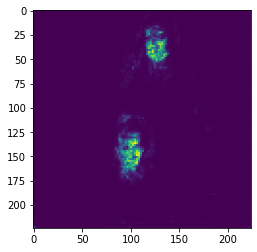

In [113]:
plt.imshow(pred_mask.reshape(224,224)*255)